# Лабораторная работа №8 по курсу "Нейроинформатика".
Выполнил Пищик Е.С. М8О-406Б-19.

## Цель работы.

Исследование свойств некоторых динамических нейронных сетей, алгоритмов обучения, а также применение сетей в задачах аппроксимации функций и распознавания динамических образов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from collections import OrderedDict
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader
from torch.optim import Adam
import torchvision.transforms as transforms
import random
from tqdm import tqdm
from collections import deque

## TDL.

In [2]:
class TDL(nn.Module):
    def __init__(self, in_features, delays=1):
        super().__init__()
        self.in_features = in_features
        self.delays = delays
        self.line = deque()
        self.clear()

    def clear(self):
        self.line.clear()
        for i in range(self.delays):
            self.line.append(torch.zeros(self.in_features))

    def push(self, inputs):
        self.line.appendleft(inputs)
    
    def forward(self, inputs=0):
        return self.line.pop()

## NARX.

In [3]:
class NARX(nn.Module):
    def __init__(self, in_features, h_features, out_features, delay1, delay2):
        super().__init__()
        self.in_features = in_features
        self.h_features = h_features
        self.out_features = out_features

        self.line1 = TDL(in_features, delay1)
        self.line2 = TDL(out_features, delay2)

        self.w1 = torch.nn.Parameter(torch.randn(in_features, h_features))
        self.w2 = torch.nn.Parameter(torch.randn(h_features, out_features))
        self.w3 = torch.nn.Parameter(torch.randn(out_features, h_features))

        self.b1 = torch.nn.Parameter(torch.ones(h_features))
        self.b2 = torch.nn.Parameter(torch.ones(out_features))

    def clear(self):
        self.line1.clear()
        self.line2.clear()

    def forward(self, inputs):
        out1 = torch.tanh(self.line1() @ self.w1 + self.line2() @ self.w3 + self.b1)
        out2 = out1 @ self.w2 + self.b2

        self.line1.push(torch.tensor(inputs))
        self.line2.push(torch.tensor(out2))

        return out2

## Обучение.

In [4]:
lr = 0.001
wd = 0.00001

model = NARX(5, 10, 5, 3, 3)
optimizer = Adam(model.parameters(), lr=lr, weight_decay=wd)

epochs = 100
n, w  = 600, 5

t = np.linspace(0, 5, n)
uk, yk = np.cos(t**2 + 10*t + 3), [0]

for i in range(n-1):
    yk += [yk[-1] / (1 + yk[-1]**2) + uk[i]]

train_data = [(np.array(uk[i:i+w], dtype=np.float32),
                np.array(yk[i:i+w], dtype=np.float32)) for i in range(n - 5)]

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)

In [5]:
model.train()

train_loss = []
crit = nn.MSELoss()

for i in range(epochs):
    pbar = tqdm(enumerate(train_loader))

    model.clear()

    epoch_loss = []

    for _, (inputs, outputs_gt) in pbar:
        outputs = model(inputs)

        loss = torch.sqrt(crit(outputs_gt, outputs))
        epoch_loss += [loss.item()]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss += [np.mean(epoch_loss)]
    pbar.write(f'{i+1} loss: {train_loss[-1]:.4f}')

0it [00:00, ?it/s]<ipython-input-3-ddc148b1b73b>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.line1.push(torch.tensor(inputs))
<ipython-input-3-ddc148b1b73b>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.line2.push(torch.tensor(out2))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
595it [00:01, 508.39it/s]


1 loss: 2.5522


595it [00:00, 1231.66it/s]


2 loss: 1.5893


595it [00:00, 1128.55it/s]


3 loss: 0.9785


595it [00:00, 954.70it/s]


4 loss: 0.5610


595it [00:00, 679.11it/s]


5 loss: 0.5015


595it [00:01, 497.78it/s]


6 loss: 0.4273


595it [00:01, 558.35it/s]


7 loss: 0.3518


595it [00:01, 547.69it/s]


8 loss: 0.2901


595it [00:01, 532.06it/s]


9 loss: 0.2073


595it [00:00, 711.50it/s]


10 loss: 0.1739


595it [00:01, 498.22it/s]


11 loss: 0.1491


595it [00:00, 964.98it/s] 


12 loss: 0.1351


595it [00:00, 1245.95it/s]


13 loss: 0.1242


595it [00:00, 1259.83it/s]


14 loss: 0.1129


595it [00:00, 1214.80it/s]


15 loss: 0.1052


595it [00:00, 1275.87it/s]


16 loss: 0.1007


595it [00:00, 1234.35it/s]


17 loss: 0.0960


595it [00:00, 1211.51it/s]


18 loss: 0.0914


595it [00:00, 1226.71it/s]


19 loss: 0.0861


595it [00:00, 1254.13it/s]


20 loss: 0.0851


595it [00:00, 1236.42it/s]


21 loss: 0.0849


595it [00:00, 1199.31it/s]


22 loss: 0.0830


595it [00:00, 1221.39it/s]


23 loss: 0.0801


595it [00:00, 1230.93it/s]


24 loss: 0.0807


595it [00:00, 1150.02it/s]


25 loss: 0.0773


595it [00:00, 1215.94it/s]


26 loss: 0.0764


595it [00:00, 1217.20it/s]


27 loss: 0.0745


595it [00:00, 1226.08it/s]


28 loss: 0.0815


595it [00:00, 1232.08it/s]


29 loss: 0.0783


595it [00:00, 1262.93it/s]


30 loss: 0.0798


595it [00:00, 1214.57it/s]


31 loss: 0.0751


595it [00:00, 1254.61it/s]


32 loss: 0.0788


595it [00:00, 1239.78it/s]


33 loss: 0.0732


595it [00:00, 1241.72it/s]


34 loss: 0.0784


595it [00:00, 1226.30it/s]


35 loss: 0.0712


595it [00:00, 1258.49it/s]


36 loss: 0.0772


595it [00:00, 1230.41it/s]


37 loss: 0.0666


595it [00:00, 1238.46it/s]


38 loss: 0.0752


595it [00:00, 1175.05it/s]


39 loss: 0.0661


595it [00:00, 1261.60it/s]


40 loss: 0.0695


595it [00:00, 1276.18it/s]


41 loss: 0.0647


595it [00:00, 1236.98it/s]


42 loss: 0.0738


595it [00:00, 1232.44it/s]


43 loss: 0.0650


595it [00:00, 1147.19it/s]


44 loss: 0.0735


595it [00:00, 1225.88it/s]


45 loss: 0.0647


595it [00:00, 1252.93it/s]


46 loss: 0.0665


595it [00:00, 1198.42it/s]


47 loss: 0.0635


595it [00:00, 1213.10it/s]


48 loss: 0.0666


595it [00:00, 1237.93it/s]


49 loss: 0.0621


595it [00:00, 1235.13it/s]


50 loss: 0.0662


595it [00:00, 1253.62it/s]


51 loss: 0.0621


595it [00:00, 1215.16it/s]


52 loss: 0.0657


595it [00:00, 1229.16it/s]


53 loss: 0.0623


595it [00:00, 1225.70it/s]


54 loss: 0.0652


595it [00:00, 1255.49it/s]


55 loss: 0.0620


595it [00:00, 1223.77it/s]


56 loss: 0.0646


595it [00:00, 1248.86it/s]


57 loss: 0.0615


595it [00:00, 1228.66it/s]


58 loss: 0.0638


595it [00:00, 1233.47it/s]


59 loss: 0.0618


595it [00:00, 1238.02it/s]


60 loss: 0.0627


595it [00:00, 1257.71it/s]


61 loss: 0.0620


595it [00:00, 1262.08it/s]


62 loss: 0.0614


595it [00:00, 1268.05it/s]


63 loss: 0.0613


595it [00:00, 1280.93it/s]


64 loss: 0.0608


595it [00:00, 1265.56it/s]


65 loss: 0.0603


595it [00:00, 1247.14it/s]


66 loss: 0.0601


595it [00:00, 1253.09it/s]


67 loss: 0.0597


595it [00:00, 1277.12it/s]


68 loss: 0.0593


595it [00:00, 1234.51it/s]


69 loss: 0.0590


595it [00:00, 1249.48it/s]


70 loss: 0.0586


595it [00:00, 1264.00it/s]


71 loss: 0.0583


595it [00:00, 1237.57it/s]


72 loss: 0.0579


595it [00:00, 1256.64it/s]


73 loss: 0.0576


595it [00:00, 1222.91it/s]


74 loss: 0.0572


595it [00:00, 1255.45it/s]


75 loss: 0.0569


595it [00:00, 1230.24it/s]


76 loss: 0.0565


595it [00:00, 1244.07it/s]


77 loss: 0.0565


595it [00:00, 1265.22it/s]


78 loss: 0.0560


595it [00:00, 1231.38it/s]


79 loss: 0.0562


595it [00:00, 1253.27it/s]


80 loss: 0.0562


595it [00:00, 1263.73it/s]


81 loss: 0.0554


595it [00:00, 1263.89it/s]


82 loss: 0.0567


595it [00:00, 1245.61it/s]


83 loss: 0.0559


595it [00:00, 1253.72it/s]


84 loss: 0.0554


595it [00:00, 1250.32it/s]


85 loss: 0.0556


595it [00:00, 1280.77it/s]


86 loss: 0.0528


595it [00:00, 1218.93it/s]


87 loss: 0.0565


595it [00:00, 1193.97it/s]


88 loss: 0.0526


595it [00:00, 1275.47it/s]


89 loss: 0.0560


595it [00:00, 1213.48it/s]


90 loss: 0.0528


595it [00:00, 1270.43it/s]


91 loss: 0.0556


595it [00:00, 1202.61it/s]


92 loss: 0.0528


595it [00:00, 1237.24it/s]


93 loss: 0.0552


595it [00:00, 1215.97it/s]


94 loss: 0.0520


595it [00:00, 1258.79it/s]


95 loss: 0.0550


595it [00:00, 1230.27it/s]


96 loss: 0.0510


595it [00:00, 1276.81it/s]


97 loss: 0.0546


595it [00:00, 1245.77it/s]


98 loss: 0.0512


595it [00:00, 1250.63it/s]


99 loss: 0.0539


595it [00:00, 1224.31it/s]

100 loss: 0.0503


## Графики

In [6]:
model.eval()
model.clear()

In [7]:
predict = []

for x, _ in train_data:
    predict += [model(x).detach().numpy().item(-1)]

<ipython-input-3-ddc148b1b73b>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.line2.push(torch.tensor(out2))


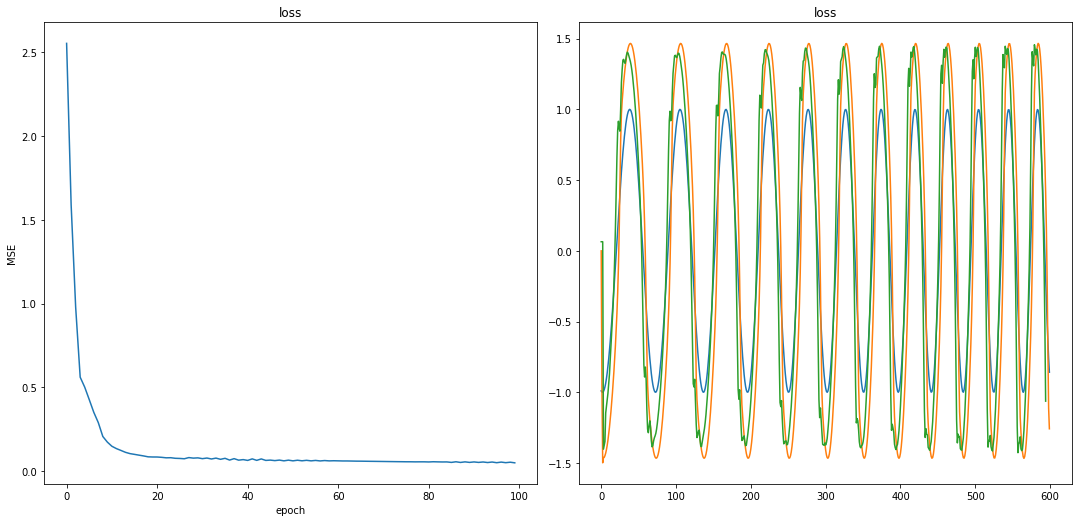

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15,7))
fig.tight_layout()

axes[0].set_title('loss')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('MSE')
axes[0].plot(train_loss)

axes[1].set_title('loss')
axes[1].plot(uk)
axes[1].plot(yk)
axes[1].plot(predict, '-')

plt.show()

## Выводы.

В данной лабораторной работе мы научились работать с сетью NARX.